<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/STAC_crawl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pystac_client. This library is used to crawl SpatioTemporal Asset Catalogs (STAC)
!pip install pystac_client --quiet
!pip install planetary_computer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 2.1 MB/s eta 0:00:00


In [13]:
##Install library to work with raster images

!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 43.3 MB/s eta 0:00:00


In [ ]:
!pip install rioxarray

In [14]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import numpy as np

In [2]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [26]:
#from pystac_client import Client
collections = list(catalog.get_collections())

# Print the number of collections
print(f"Number of collections in the base catalog: {len(collections)}")

Number of collections in the base catalog: 123


In [ ]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(collections=["landsat-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)



In [ ]:
for item in items:
    print(f"Item ID: {item.id}")

    # Print the asset names (keys) for each item
    print("Assets:")
    for asset_key in item.assets:
        print(f"  - {asset_key}: {item.assets[asset_key].href}")
    print("---------------------------------------------------")

In [4]:
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-122.72549 48.50884, -120.29248 48.0...",30,2022-05-06T18:04:17.126358Z,10.5066/P9OGBGM6,2020-12-29T18:55:56.738265Z,landsat-8,32610,"[7881, 7781]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80460272020364LGN00,046,2,162.253231,L2SP,17.458298,100.00,02,T2
1,"POLYGON ((-124.52046 48.44245, -121.93932 48.0...",30,2022-05-06T17:25:29.626986Z,10.5066/P9C7I13B,2020-12-28T18:20:32.609164Z,landsat-7,32610,"[7361, 8341]",Landsat Collection 2 Level-2,[etm+],...,027,LE70470272020363EDC00,047,2,152.689113,L2SP,14.678880,32.00,02,T1
2,"POLYGON ((-122.96802 48.44547, -120.39024 48.0...",30,2022-05-06T18:01:04.319403Z,10.5066/P9C7I13B,2020-12-21T18:14:50.812768Z,landsat-7,32610,"[7251, 8251]",Landsat Collection 2 Level-2,[etm+],...,027,LE70460272020356EDC00,046,2,153.649177,L2SP,14.779612,24.00,02,T2
3,"POLYGON ((-124.27547 48.50831, -121.84167 48.0...",30,2022-05-06T17:46:22.246696Z,10.5066/P9OGBGM6,2020-12-20T19:02:09.878796Z,landsat-8,32610,"[7971, 7861]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80470272020355LGN00,047,2,163.360118,L2SP,17.414441,100.00,02,T2
4,"POLYGON ((-122.72996 48.50858, -120.29690 48.0...",30,2022-05-06T18:04:16.935800Z,10.5066/P9OGBGM6,2020-12-13T18:56:00.096447Z,landsat-8,32610,"[7881, 7781]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80460272020348LGN00,046,2,164.126188,L2SP,17.799744,98.64,02,T2
5,"POLYGON ((-124.51935 48.44597, -121.93965 48.0...",30,2022-05-06T17:25:29.412798Z,10.5066/P9C7I13B,2020-12-12T18:21:42.991249Z,landsat-7,32610,"[7361, 8341]",Landsat Collection 2 Level-2,[etm+],...,027,LE70470272020347EDC00,047,2,154.692691,L2SP,15.427422,12.00,02,T1
6,"POLYGON ((-122.98709 48.44790, -120.40945 48.0...",30,2022-05-06T18:01:04.178839Z,10.5066/P9C7I13B,2020-12-05T18:16:03.755599Z,landsat-7,32610,"[7281, 8251]",Landsat Collection 2 Level-2,[etm+],...,027,LE70460272020340EDC00,046,2,155.308739,L2SP,16.313570,2.00,02,T1
7,"POLYGON ((-124.27385 48.50833, -121.83965 48.0...",30,2022-05-06T17:46:22.097338Z,10.5066/P9OGBGM6,2020-12-04T19:02:11.194486Z,landsat-8,32610,"[7971, 7861]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80470272020339LGN00,047,2,164.914060,L2SP,18.807230,1.90,02,T1


In [5]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
print(selected_item)

<Item id=LC08_L2SP_047027_20201204_02_T1>


In [6]:
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Description                                                          ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ qa               │ Surface Temperature Quality Assessment Band                          │
│ ang              │ Angle Coefficients File                                              │
│ red              │ Red Band                                                             │
│ blue             │ Blue Band                                                            │
│ drad             │ Downwelled Radiance Band                                             │
│ emis             │ Emissivity Band                                                      │
│ emsd             │ Emissivity Standard Deviation Band                                   │
│ trad             │ Thermal Radiance Band                                                │
│ urad             │ Upwelled Radiance Band                                               │
│ atran            │ Atmospheric Transmittance Band                                       │
│ cdist            │ Cloud Distance Band                                                  │
│ green            │ Green Band                                                           │
│ nir08            │ Near Infrared Band 0.8                                               │
│ lwir11           │ Surface Temperature Band                                             │
│ swir16           │ Short-wave Infrared Band 1.6                                         │
│ swir22           │ Short-wave Infrared Band 2.2                                         │
│ coastal          │ Coastal/Aerosol Band                                                 │
│ mtl.txt          │ Product Metadata File (txt)                                          │
│ mtl.xml          │ Product Metadata File (xml)                                          │
│ mtl.json         │ Product Metadata File (json)                                         │
│ qa_pixel         │ Pixel Quality Assessment Band                                        │
│ qa_radsat        │ Radiometric Saturation and Terrain Occlusion Quality Assessment Band │
│ qa_aerosol       │ Aerosol Quality Assessment Band                                      │
│ tilejson         │ TileJSON with default rendering                                      │
│ rendered_preview │ Rendered preview                                                     │
└──────────────────┴──────────────────────────────────────────────────────────────────────┘

In [7]:
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-c2-l2&item=LC08_L2SP_047027_20201204_02_T1&assets=red&assets=green&assets=blue&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55&format=png',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

In [8]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

In [9]:
selected_item.assets["blue"].href[:250]

'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_SR_B2.TIF?st=2024-03-10T22%3A39%3A37Z&se=2024-03-11T23%3A24%3A37Z&sp=rl&sv'

In [10]:
import requests

requests.head(selected_item.assets["blue"].href).status_code

200

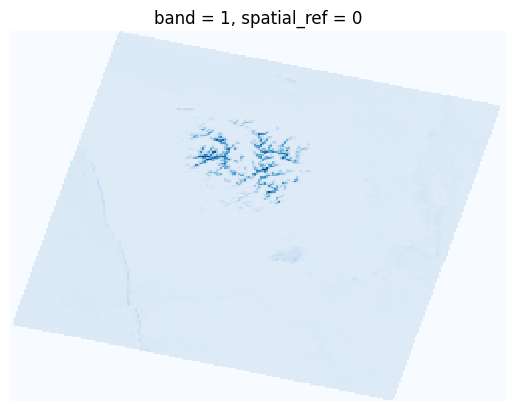

In [20]:
# import xarray as xr
import rioxarray

ds = rioxarray.open_rasterio(
    selected_item.assets["blue"].href, overview_level=4
).squeeze()
img = ds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();

In [ ]:
ds

In [25]:
img

In [21]:
##Retrieve the file size of the COG

# Send an HTTP HEAD request
response = requests.head(selected_item.assets["blue"].href)

if response.status_code == 200:
    # Check if 'Content-Length' header is available
    if 'Content-Length' in response.headers:
        file_size_bytes = int(response.headers['Content-Length'])
        print(f"File Size: {file_size_bytes} bytes")
    else:
        print("Content-Length header is not available.")
else:
    print(f"Failed to access the file. Status code: {response.status_code}")

File Size: 78925124 bytes
